## Reto de Data Science en DEACERO - Predicción de precio de varilla corrugada
### **Script:** Calidad de datos, y Construcción de Modelo.

**Tags:** #datacleaning, #datapreprocessing, #featureengineering, # model, # predicción

**Autor:** Alessio Daniel Hernández Rojas

**Última actualización: 29-12-2025 (Creado: 28-12-2025)

**Descripción:** El presente script tiene como objetivo realizar el análisis de desarrollo de una API HTTP RESTful para predicción de precio de varilla corrugada. En particular, este script aborda: 1) Limpieza, 2) preprocesamiento de datos y 3) el modelo para predicción de precio.

**Entrada:** Base de datos compuesta

**Salida:** NONE

#### Instalación de librerias

In [476]:
# Instalación de librerias necesarias
#!pip install fastapi
#!pip install uvicorn
#!pip install folium
#!pip install geopandas
#!pip install contextily
#!pip install dash
#!pip install folium

#### Importación de librerias

In [477]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
from datetime import datetime
from sklearn.ensemble import IsolationForest
#import folium
import random
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import yfinance as yf
from pandas_datareader import data as pdr
import datetime as dt
from sklearn.preprocessing import StandardScaler
import plotly.express as px

from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error

#### Funciones

In [478]:
# Renombre de columnas
def rename_cols(df,cols,prefix):
    new_feats=[prefix+col for col in cols]
    df=df.rename(columns=dict(zip(cols,new_feats)))
    return df

# Completitud
def completitud(df):
    comple=pd.DataFrame(df.isnull().sum())
    comple.reset_index(inplace=True)
    comple=comple.rename(columns={"index":"columna",0:"total"})
    comple["completitud"]=(1-comple["total"]/df.shape[0])*100
    comple=comple.sort_values(by="completitud",ascending=True)
    comple.reset_index(drop=True,inplace=True)
    return comple

# Filtro de completitud
def filtrar_por_completitud(df, umbral=90):
    """
    Filtra las columnas de un DataFrame que tengan una completitud menor al umbral indicado.
    Imprime las columnas eliminadas junto con su porcentaje de completitud.
    Devuelve el DataFrame filtrado.
    """
    # Calcular completitud
    comple = pd.DataFrame(df.isnull().sum())
    comple.reset_index(inplace=True)
    comple = comple.rename(columns={"index": "columna", 0: "total"})
    comple["completitud"] = (1 - comple["total"] / df.shape[0]) * 100

    # Identificar columnas que no cumplen el umbral
    eliminadas = comple.loc[comple["completitud"] < umbral, ["columna", "completitud"]]
    conservadas = comple.loc[comple["completitud"] >= umbral, "columna"]

    # Imprimir reporte
    if not eliminadas.empty:
        print("📉 Columnas eliminadas por baja completitud:")
        for _, row in eliminadas.iterrows():
            print(f" - {row['columna']}: {row['completitud']:.2f}% de completitud")
    else:
        print("✅ No se eliminaron columnas, todas cumplen el umbral.")

    # Retornar DataFrame filtrado
    return df[conservadas]

# Filtro de variables unarias ponderadas
def unarias_ponderadas(df, umbral=0.95, mostrar_sesgo=True):
    """
    Detecta variables en las que una categoría supera el umbral de proporción.
    Puede además mostrar el sesgo (distribución porcentual) de cada variable detectada.
    """
    unarias = []

    for v in df.columns:
        # Distribución de frecuencias relativas
        evaluacion = df[v].value_counts(normalize=True).reset_index()
        evaluacion.columns = [v, "proporcion"]

        # Verificar si la categoría dominante supera el umbral
        if evaluacion["proporcion"].iloc[0] > umbral:
            unarias.append(v)

            if mostrar_sesgo:
                print(f"\n🔍 Variable: {v}")
                print(evaluacion.to_string(index=False, formatters={"proporcion": "{:.2%}".format}))

    if not unarias:
        print("✅ No se encontraron variables unarias por encima del umbral.")

    return unarias


def descriptivos(df, tipo_variable = "v_"):
    for col in df.filter(like= tipo_variable ).columns:
        print(col)
        value_counts = df[col].value_counts(1)
        mydf = pd.DataFrame(value_counts)
        mydf['cumulativo'] = df[col].value_counts().cumsum() / df[col].value_counts().sum()
        mydf['total'] = df[col].value_counts()
        mydf['total_cumulativo'] = df[col].value_counts().cumsum()
        display(mydf)
        print()
        print("\n")


def plot_eda_cat(df, prefix, title):
    """
    Grafica variables categóricas (que comienzan con 'prefix') como barras horizontales.
    Muestra frecuencias y porcentajes, ajustando la altura según el número de categorías.
    """

    # Filtrar columnas que empiezan con el prefijo
    lista_categoricas = [col for col in df.columns if col.startswith(prefix)]

    for current_cat in lista_categoricas:
        # Frecuencias absolutas y totales
        counts = df[current_cat].value_counts().sort_values(ascending=True)
        total = counts.sum()

        # Altura dinámica según número de categorías
        n_cat = len(counts)
        fig_height = max(400, 30 * n_cat + 150)

        # Gráfico de barras
        fig = go.Figure([
            go.Bar(
                x=counts.values,
                y=counts.index,
                orientation='h',
                text=[f"{v} ({v/total*100:.1f}%)" for v in counts],
                textposition='auto',
                marker=dict(color='steelblue')
            )
        ])

        # Diseño
        fig.update_layout(
            title=dict(text=f"<b>{title} – {current_cat}</b>", x=0.5, font=dict(size=20)),
            xaxis_title="Frecuencia",
            yaxis_title="Categoría",
            width=800,
            height=fig_height,
            margin=dict(t=80, l=180, r=50, b=60),
            showlegend=False,
            template="plotly_white"
        )

        # Mostrar todas las categorías en el eje Y
        fig.update_yaxes(tickmode='array', tickvals=list(counts.index), ticktext=list(counts.index))

        fig.show()



def plot_eda_num(df, prefix='num_', titulo='Exploratory Data Analysis (EDA)'):
    """
    Genera histogramas con curva KDE + boxplot (abajo) para todas las variables numéricas 
    cuyo nombre contiene el prefijo indicado, mostrando una leyenda independiente
    dentro de cada subplot.

    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame con las variables a analizar.
    prefix : str, opcional (por defecto 'num_')
        Prefijo que deben tener las columnas numéricas a analizar.
    titulo : str, opcional
        Título general mostrado en cada figura.
    """

    # --- Solo columnas que COMIENZAN con el prefijo ---
    lista_numericas = [col for col in df.columns if col.startswith(prefix)]
    print(f"Total de variables que cumplen con '{prefix}': {len(lista_numericas)}\n")

    for col in lista_numericas:
        x = df[col].dropna()

        # --- Histograma (densidad normalizada) ---
        hist_vals, bin_edges = np.histogram(x, bins=38, density=True)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

        # --- KDE ---
        kde = gaussian_kde(x)
        kde_x = np.linspace(x.min(), x.max(), 500)
        kde_y = kde(kde_x)

        # --- Estadísticos descriptivos ---
        skew = df[col].skew()
        mean = df[col].mean()
        median = df[col].median()

        # --- Subplots: histograma + boxplot ---
        fig = make_subplots(
            rows=2, cols=1,
            shared_xaxes=True,
            row_heights=[0.75, 0.25],
            vertical_spacing=0.08
        )

        # --- Histograma ---
        fig.add_trace(go.Bar(
            x=bin_centers,
            y=hist_vals,
            name="Histograma",
            marker=dict(color='rgba(70,130,180,0.7)', line=dict(color='white', width=1)),
            hovertemplate='Valor: %{x:.2f}<br>Densidad: %{y:.4e}<extra></extra>'
        ), row=1, col=1)

        # --- KDE ---
        fig.add_trace(go.Scatter(
            x=kde_x,
            y=kde_y,
            mode="lines",
            name="KDE",
            line=dict(color="red", width=2, dash="dash"),
            hovertemplate='Valor: %{x:.2f}<br>Densidad KDE: %{y:.4e}<extra></extra>'
        ), row=1, col=1)

        # --- Boxplot (abajo) ---
        fig.add_trace(go.Box(
            x=x,
            name="Boxplot",
            boxmean=True,
            marker_color='rgba(255,165,0,0.7)',
            line=dict(width=1),
            orientation='h',
            showlegend=False
        ), row=2, col=1)

        # --- Diseño ---
        fig.update_layout(
            title=dict(
                text=f"<b>{titulo} - {col}</b><br>Media: {mean:.2f}, Mediana: {median:.2f}, Asimetría: {skew:.2f}",
                x=0.5,
                font=dict(size=18)
            ),
            xaxis_title=col,
            yaxis_title="Densidad (escala normalizada)",
            yaxis_tickformat='.1e',  # notación científica (tipo 20n, 40n)
            width=800,
            height=600,
            template="plotly_white",
            showlegend=True,
            # 👇 Leyenda dentro del primer subplot
            legend=dict(
                x=0.98, y=0.95,
                xanchor='right', yanchor='top',
                bgcolor='rgba(255,255,255,0.6)',
                bordercolor='gray',
                borderwidth=1,
                font=dict(size=12)
            ),
            margin=dict(t=100, l=70, r=40, b=70)
        )

        fig.update_yaxes(title_text="Boxplot", row=2, col=1, showticklabels=False)
        fig.show()

# Plot matriz de correlación
def plot_corr_matrix(df, prefix, title="Matriz de correlación"):
    """
    Muestra un mapa de calor triangular inferior (sin diagonal)
    con los valores de correlación para variables que inician con 'prefix',
    ocultando los NaN y con etiquetas en negritas.
    """
    # Filtrar columnas que comienzan con el prefijo
    cols = [c for c in df.columns if c.startswith(prefix)]
    df_sub = df[cols]

    # Calcular matriz de correlación
    corr = df_sub.corr(numeric_only=True)

    # Máscara: mostrar solo la parte inferior (sin diagonal)
    mask = np.tril(np.ones_like(corr, dtype=bool), k=-1)
    corr_masked = corr.where(mask)

    # Reemplazar NaN por None para que no se muestren en el heatmap
    z_vals = corr_masked.where(~corr_masked.isna(), None)

    # Crear figura
    fig = go.Figure(
        data=go.Heatmap(
            z=z_vals.values,
            x=corr_masked.columns,
            y=corr_masked.index,
            colorscale="RdBu",
            zmin=-1, zmax=1,
            text=corr_masked.round(2).astype(str).replace("nan", ""),
            texttemplate="%{text}",
            textfont={"size": 14},
            hoverongaps=False,
            colorbar=dict(title="Correlación")
        )
    )

    # Ajustar layout
    fig.update_layout(
        title=dict(text=f"<b>{title}</b>", x=0.5, font=dict(size=18)),
        xaxis=dict(
            title=dict(text="<b>Variables</b>", font=dict(size=14, family="Arial", color="black")),
            tickangle=45,
            tickfont=dict(size=12, family="Arial", color="black")
        ),
        yaxis=dict(
            title=dict(text="<b>Variables</b>", font=dict(size=14, family="Arial", color="black")),
            autorange="reversed",
            tickfont=dict(size=12, family="Arial", color="black")
        ),
        width=800,
        height=800,
        margin=dict(l=100, r=50, t=80, b=100)
    )

    fig.show()

# EDA completo
def compute_EDA(df):
  df_eda = df.copy()
  print("Dimensiones del dataset:", df_eda.shape)
  plot_eda_cat(df_eda, prefix='cat_', title='Distribución en Variables Categoricas')
  plot_eda_num(df_eda, prefix='num_', titulo='Distribuciones en Variables Numéricas')
  plot_corr_matrix(df_eda, prefix='num_', title='Matriz de Correlación para Variables Numéricas')
  completitud_df = completitud(df_eda)
  display(completitud_df)



# Detección y eliminación de outliers con Isolation Forest
def remove_outliers_iforest(df, prefix='num_', contamination=0.02, random_state=42):
    # Filtrar columnas numéricas
    num_cols = [c for c in df.columns if c.startswith(prefix)]
    X = df[num_cols].dropna()

    # Modelo
    iso = IsolationForest(contamination=contamination, random_state=random_state)
    preds = iso.fit_predict(X)

    # Filtrar outliers (preds = -1 son outliers)
    df_filtered = df.loc[X.index[preds == 1]]

    print(f"✅ Registros conservados: {len(df_filtered)} / {len(df)} ({len(df_filtered)/len(df)*100:.1f}%)")
    return df_filtered

#### Lectura de dataset 

In [479]:
# Cargar el dataset de precio de varilla corrugada
df_target = pd.read_csv('data/Steel_Rebar_Futures_Historical_Data.csv')
df_target["Date"] = pd.to_datetime(df_target["Date"])
df_target = df_target.sort_values("Date").set_index("Date")

# Nos quedamos solo con el precio de cierre
df_target = df_target[["Price"]].rename(columns={"Price": "rebar_price"}) # USD/ton
display(df_target)

,rebar_price
Date,
2016-01-04,327.0
2016-01-05,327.0
2016-01-06,327.0
2016-01-07,327.0
2016-01-08,327.0
...,...
2025-10-23,543.0
2025-10-24,544.0
2025-10-27,545.0


In [480]:
yf_tickers = {
    "HRC=F": "hot_rolled_coil_price",    # Precio de Acero laminado en caliente - Hot Rolled Coil Steel USD/ton; La varilla corrugada se produce a partir de acero largo
    "TIO=F": "iron_ore_price",           # Precio de Mineral de hierro - Iron Ore USD/ton; materia prima principal de acero
    "MTF=F": "coking_coal_price",        # Precio de Carbón coquizable (para alto horno). - Coking Coal USD/ton
    "HG=F": "copper_price",              # Precio del cobre - Copper USD/libra
    "CL=F": "crude_oil_price",           # Precio del petroleo - Crude Oil USD/barril
    "USDCNY=X": "usd_cny",               # Tipo de cambio USD / Yuan chino (CNY)  CNY/dolar americano
    "ALI=F": "aluminum_price",           # Precio de Aluminio USD/ton
    "DX-Y.NYB": "dollar_index",          # mide la fortaleza del dólar estadounidense  índice(base 100)
    "^VIX": "vix",                       # volatilidad esperada del S&P 500     índice(puntos de volatilidad)
    "^GSPC": "sp500"                     # índice bursátil de las 500 empresas más grandes de EE. UU
}

df_yf  = yf.download(
    list(yf_tickers.keys()),
    start="2016-01-01",
    auto_adjust=True,
    progress=False
    )

df_yf = df_yf["Close"]  # solo precios de cierre

df_yf = df_yf.rename(columns=yf_tickers) # renombre de columnas


start = dt.datetime(2016, 1, 1)

df_fx = pdr.DataReader(
    "DEXMXUS",  # Tipo de cambio USD/ MXN   MXN/ dolar americano
    "fred",
    start
)

df_fx.columns = ["usd_mxn"]



In [481]:
df = pd.concat([df_target, df_yf, df_fx], axis=1).round(1)
df = df.sort_index()
display(df)
df = df.asfreq("B") # Fija frecuencia de días hábiles (CRÍTICO)
display(df)

,rebar_price,aluminum_price,crude_oil_price,dollar_index,copper_price,hot_rolled_coil_price,coking_coal_price,iron_ore_price,usd_cny,sp500,vix,usd_mxn
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,NaN,NaN,NaN
2016-01-04,327.0,1601.5,36.8,98.9,2.1,395.0,NaN,42.0,6.5,2012.7,20.7,17.4
2016-01-05,327.0,1593.2,36.0,99.4,2.1,395.0,47.8,41.7,6.5,2016.7,19.3,17.4
2016-01-06,327.0,1607.0,34.0,99.2,2.1,398.0,48.4,41.1,6.5,1990.3,20.6,17.4
2016-01-07,327.0,1607.8,33.3,98.2,2.0,401.0,48.5,41.1,6.5,1943.1,25.0,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-22,NaN,2850.2,58.0,98.3,5.4,908.0,96.5,106.9,7.0,6878.5,14.1,NaN
2025-12-23,NaN,2857.5,58.4,97.9,5.5,908.0,96.5,106.9,7.0,6909.8,14.0,NaN
2025-12-24,NaN,2865.8,58.3,98.0,5.5,906.0,96.6,106.9,7.0,6932.0,13.5,NaN
2025-12-26,NaN,2924.8,56.7,98.0,5.8,906.0,96.0,107.0,7.0,6929.9,13.6,NaN


,rebar_price,aluminum_price,crude_oil_price,dollar_index,copper_price,hot_rolled_coil_price,coking_coal_price,iron_ore_price,usd_cny,sp500,vix,usd_mxn
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,NaN,NaN,NaN
2016-01-04,327.0,1601.5,36.8,98.9,2.1,395.0,NaN,42.0,6.5,2012.7,20.7,17.4
2016-01-05,327.0,1593.2,36.0,99.4,2.1,395.0,47.8,41.7,6.5,2016.7,19.3,17.4
2016-01-06,327.0,1607.0,34.0,99.2,2.1,398.0,48.4,41.1,6.5,1990.3,20.6,17.4
2016-01-07,327.0,1607.8,33.3,98.2,2.0,401.0,48.5,41.1,6.5,1943.1,25.0,17.7
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-23,NaN,2857.5,58.4,97.9,5.5,908.0,96.5,106.9,7.0,6909.8,14.0,NaN
2025-12-24,NaN,2865.8,58.3,98.0,5.5,906.0,96.6,106.9,7.0,6932.0,13.5,NaN
2025-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-26,NaN,2924.8,56.7,98.0,5.8,906.0,96.0,107.0,7.0,6929.9,13.6,NaN


#### Exploración cruda de dataset

In [482]:
# Tamaño del dataset
print("Dimensiones del dataset:", df.shape)

Dimensiones del dataset: (2607, 12)


In [483]:
# Completitud del dataset
completitud_df = completitud(df)
print(completitud_df)

                  columna  total  completitud
0          aluminum_price    132    94.936709
1             rebar_price    126    95.166858
2                 usd_mxn    117    95.512083
3       coking_coal_price    112    95.703874
4   hot_rolled_coil_price    107    95.895666
5          iron_ore_price     97    96.279248
6            copper_price     95    96.355965
7         crude_oil_price     95    96.355965
8                     vix     95    96.355965
9                   sp500     95    96.355965
10           dollar_index     94    96.394323
11                usd_cny      8    99.693134


In [484]:
# Descripción estadística del dataset
display(df.describe())

,rebar_price,aluminum_price,crude_oil_price,dollar_index,copper_price,hot_rolled_coil_price,coking_coal_price,iron_ore_price,usd_cny,sp500,vix,usd_mxn
count,2481.000000,2475.000000,2512.000000,2513.000000,2512.000000,2500.000000,2495.000000,2510.000000,2599.000000,2512.000000,2512.000000,2490.000000
mean,547.265659,2228.338788,63.608081,98.517708,3.459753,829.429600,109.960361,101.056056,6.846441,3767.954220,18.500955,19.324418
std,116.401820,386.026438,17.528086,5.028612,0.872273,332.296559,71.647110,33.647781,0.292966,1290.192879,7.334697,1.405333
min,318.800000,1452.000000,-37.600000,88.600000,1.900000,390.000000,38.600000,40.300000,6.300000,1829.100000,9.100000,16.300000
25%,448.500000,1957.400000,51.375000,94.700000,2.700000,613.000000,65.800000,74.925000,6.600000,2711.625000,13.500000,18.425000
50%,550.500000,2244.500000,63.400000,97.800000,3.400000,732.000000,94.600000,99.900000,6.900000,3673.800000,16.700000,19.200000
75%,609.000000,2449.100000,74.200000,102.400000,4.200000,906.000000,118.200000,118.300000,7.100000,4513.550000,21.500000,20.100000
max,950.000000,3873.000000,123.700000,114.100000,5.800000,1945.000000,438.400000,219.800000,7.300000,6932.000000,82.700000,25.100000


#### Renombrado de características

In [485]:
# Identificación de nombres de columnas
display(df.columns.to_list())

['rebar_price',
 'aluminum_price',
 'crude_oil_price',
 'dollar_index',
 'copper_price',
 'hot_rolled_coil_price',
 'coking_coal_price',
 'iron_ore_price',
 'usd_cny',
 'sp500',
 'vix',
 'usd_mxn']

In [486]:
# Mapeo manual de variables de acuerdo a tipo
id_feats = []
date_feats = []
num_feats = ['aluminum_price', 'crude_oil_price', 'dollar_index', 'copper_price', 'hot_rolled_coil_price', 'coking_coal_price', 'iron_ore_price', 'usd_cny', 'sp500', 'vix', 'usd_mxn']
cat_feats=[]
text_feats = []
geo_feats = []
tgt_feats = ['rebar_price']

# Renombrado aplicado 
df=rename_cols(df, id_feats,"id_")
df=rename_cols(df, date_feats,"date_")
df=rename_cols(df, num_feats,"num_")
df=rename_cols(df, cat_feats,"cat_")
df=rename_cols(df, text_feats,"text_")
df=rename_cols(df, geo_feats,"geo_")
df=rename_cols(df, tgt_feats,"tgt_")

# Completitud del dataset
completitud_df = completitud(df)
print(completitud_df)

                      columna  total  completitud
0          num_aluminum_price    132    94.936709
1             tgt_rebar_price    126    95.166858
2                 num_usd_mxn    117    95.512083
3       num_coking_coal_price    112    95.703874
4   num_hot_rolled_coil_price    107    95.895666
5          num_iron_ore_price     97    96.279248
6            num_copper_price     95    96.355965
7         num_crude_oil_price     95    96.355965
8                     num_vix     95    96.355965
9                   num_sp500     95    96.355965
10           num_dollar_index     94    96.394323
11                num_usd_cny      8    99.693134


In [487]:
# Tipos de datos
print(df.dtypes)

tgt_rebar_price              float64
num_aluminum_price           float64
num_crude_oil_price          float64
num_dollar_index             float64
num_copper_price             float64
num_hot_rolled_coil_price    float64
num_coking_coal_price        float64
num_iron_ore_price           float64
num_usd_cny                  float64
num_sp500                    float64
num_vix                      float64
num_usd_mxn                  float64
dtype: object


No hay necesidad de cambiar tipo de dato

#### Eliminación de Duplicados

En datos de series temporales esto no lo usamos

#### Eliminación de variables por completitud

In [488]:
# Eliminación de variables por completitud abajo del 80%
df = filtrar_por_completitud(df, umbral=80)
# Completitud del dataset
completitud_df = completitud(df)
print(completitud_df)

✅ No se eliminaron columnas, todas cumplen el umbral.
                      columna  total  completitud
0          num_aluminum_price    132    94.936709
1             tgt_rebar_price    126    95.166858
2                 num_usd_mxn    117    95.512083
3       num_coking_coal_price    112    95.703874
4   num_hot_rolled_coil_price    107    95.895666
5          num_iron_ore_price     97    96.279248
6            num_copper_price     95    96.355965
7         num_crude_oil_price     95    96.355965
8                     num_vix     95    96.355965
9                   num_sp500     95    96.355965
10           num_dollar_index     94    96.394323
11                num_usd_cny      8    99.693134


#### Eliminación de variables categoricas unitarias

In [489]:
# Eliminación de variables categoricas unitarias
unarias_umbral = unarias_ponderadas(df, 0.9)
print(unarias_umbral)

✅ No se encontraron variables unarias por encima del umbral.
[]


In [490]:
# Eliminamos variables ""
df = df.drop(unarias_umbral)
# Completitud del dataset
completitud_df = completitud(df)
print(completitud_df)

                      columna  total  completitud
0          num_aluminum_price    132    94.936709
1             tgt_rebar_price    126    95.166858
2                 num_usd_mxn    117    95.512083
3       num_coking_coal_price    112    95.703874
4   num_hot_rolled_coil_price    107    95.895666
5          num_iron_ore_price     97    96.279248
6            num_copper_price     95    96.355965
7         num_crude_oil_price     95    96.355965
8                     num_vix     95    96.355965
9                   num_sp500     95    96.355965
10           num_dollar_index     94    96.394323
11                num_usd_cny      8    99.693134


#### Descriptivos de variables categóricos

In [491]:
# Descriptivos categóricos
descriptivos(df, tipo_variable = "cat_")

**Observaciones**:

No hay variables categóricas


#### Normalización de variables categoricas

**Observaciones**:

No hay variables categóricas

#### Descriptivos de variables numéricos

In [492]:
# Descriptivos numéricos
#descriptivos(df, tipo_variable = "num_")
df.describe()

,tgt_rebar_price,num_aluminum_price,num_crude_oil_price,num_dollar_index,num_copper_price,num_hot_rolled_coil_price,num_coking_coal_price,num_iron_ore_price,num_usd_cny,num_sp500,num_vix,num_usd_mxn
count,2481.000000,2475.000000,2512.000000,2513.000000,2512.000000,2500.000000,2495.000000,2510.000000,2599.000000,2512.000000,2512.000000,2490.000000
mean,547.265659,2228.338788,63.608081,98.517708,3.459753,829.429600,109.960361,101.056056,6.846441,3767.954220,18.500955,19.324418
std,116.401820,386.026438,17.528086,5.028612,0.872273,332.296559,71.647110,33.647781,0.292966,1290.192879,7.334697,1.405333
min,318.800000,1452.000000,-37.600000,88.600000,1.900000,390.000000,38.600000,40.300000,6.300000,1829.100000,9.100000,16.300000
25%,448.500000,1957.400000,51.375000,94.700000,2.700000,613.000000,65.800000,74.925000,6.600000,2711.625000,13.500000,18.425000
50%,550.500000,2244.500000,63.400000,97.800000,3.400000,732.000000,94.600000,99.900000,6.900000,3673.800000,16.700000,19.200000
75%,609.000000,2449.100000,74.200000,102.400000,4.200000,906.000000,118.200000,118.300000,7.100000,4513.550000,21.500000,20.100000
max,950.000000,3873.000000,123.700000,114.100000,5.800000,1945.000000,438.400000,219.800000,7.300000,6932.000000,82.700000,25.100000


**Observaciones**:

Numéricas:

* None

#### Consistencia de variables (númericas y categóricas)

Se asume que los valores estan en rangos aceptables

### Analísis Exploratorio de datos

In [493]:
# Análisis exploratorio visual completo
compute_EDA(df)

Dimensiones del dataset: (2607, 12)
Total de variables que cumplen con 'num_': 11



,columna,total,completitud
0,num_aluminum_price,132,94.936709
1,tgt_rebar_price,126,95.166858
2,num_usd_mxn,117,95.512083
3,num_coking_coal_price,112,95.703874
4,num_hot_rolled_coil_price,107,95.895666
5,num_iron_ore_price,97,96.279248
6,num_copper_price,95,96.355965
7,num_crude_oil_price,95,96.355965
8,num_vix,95,96.355965
9,num_sp500,95,96.355965


**Observaciones**:

> Categóricas:

No hay variables categóricas

> Numéricas:

En este analisis de series de tiempo no eliminaremos valores 

> Correlación:

Al ser una serie de tiempo la correlación lineal no aporta mucha información

In [494]:
fig = px.line(
    df,
    x=df.index,
    y="tgt_rebar_price",
    title="<b>Steel Rebar Price – Daily Close (USD/ton)</b>"
)

fig.show()

#### Eliminación de registros con valores atípicos (“Outliers”) en variables númericas

Asumimos que en Time Series los outliers son señal

#### Imputación de valores ausentes

In [495]:
df_eda = df.copy()
# Todas las features + target
cols = [c for c in df_eda.columns if c.startswith(("tgt_", "num_"))]

# 1. Rellenar NA
df_eda[cols] = df_eda[cols].ffill().bfill()

df_completitud = completitud(df_eda)
display(df_completitud)


# 2. Escalamos para poder comparar series en la misma gráfica
scaler = StandardScaler()
df_eda[cols] = scaler.fit_transform(df_eda[cols])

fig = px.line(
    df_eda,
    x=df_eda.index,
    y=cols,
    title="<b>Rebar Price vs All Drivers (Standardized)</b>"
)

fig.show()


,columna,total,completitud
0,tgt_rebar_price,0,100.0
1,num_aluminum_price,0,100.0
2,num_crude_oil_price,0,100.0
3,num_dollar_index,0,100.0
4,num_copper_price,0,100.0
5,num_hot_rolled_coil_price,0,100.0
6,num_coking_coal_price,0,100.0
7,num_iron_ore_price,0,100.0
8,num_usd_cny,0,100.0
9,num_sp500,0,100.0


#### Feature Engineering

In [496]:
lag_features = [
    "tgt_rebar_price",
    "num_aluminum_price",
    "num_crude_oil_price",
    "num_copper_price",
    "num_hot_rolled_coil_price",
    "num_coking_coal_price",
    "num_iron_ore_price"
]

for col in lag_features:
    for lag in [1, 3, 5, 7]:
        df[f"{col}_lag{lag}"] = df[col].shift(lag)

In [497]:
df["target_t_plus_1"] = df["tgt_rebar_price"].shift(-1)
display(df)

,tgt_rebar_price,num_aluminum_price,num_crude_oil_price,num_dollar_index,num_copper_price,num_hot_rolled_coil_price,num_coking_coal_price,num_iron_ore_price,num_usd_cny,num_sp500,...,num_hot_rolled_coil_price_lag7,num_coking_coal_price_lag1,num_coking_coal_price_lag3,num_coking_coal_price_lag5,num_coking_coal_price_lag7,num_iron_ore_price_lag1,num_iron_ore_price_lag3,num_iron_ore_price_lag5,num_iron_ore_price_lag7,target_t_plus_1
2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327.0
2016-01-04,327.0,1601.5,36.8,98.9,2.1,395.0,NaN,42.0,6.5,2012.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327.0
2016-01-05,327.0,1593.2,36.0,99.4,2.1,395.0,47.8,41.7,6.5,2016.7,...,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN,NaN,327.0
2016-01-06,327.0,1607.0,34.0,99.2,2.1,398.0,48.4,41.1,6.5,1990.3,...,NaN,47.8,NaN,NaN,NaN,41.7,NaN,NaN,NaN,327.0
2016-01-07,327.0,1607.8,33.3,98.2,2.0,401.0,48.5,41.1,6.5,1943.1,...,NaN,48.4,NaN,NaN,NaN,41.1,42.0,NaN,NaN,327.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-23,NaN,2857.5,58.4,97.9,5.5,908.0,96.5,106.9,7.0,6909.8,...,907.0,96.5,97.0,95.8,96.8,106.9,106.9,106.4,106.1,NaN
2025-12-24,NaN,2865.8,58.3,98.0,5.5,906.0,96.6,106.9,7.0,6932.0,...,907.0,96.5,96.9,96.5,96.1,106.9,106.9,106.6,106.1,NaN
2025-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,907.0,96.6,96.5,97.0,95.8,106.9,106.9,106.9,106.4,NaN
2025-12-26,NaN,2924.8,56.7,98.0,5.8,906.0,96.0,107.0,7.0,6929.9,...,907.0,NaN,96.5,96.9,96.5,NaN,106.9,106.9,106.6,NaN


In [498]:
df = df.drop(columns=[
    "tgt_rebar_price",
    "num_aluminum_price",
    "num_crude_oil_price",
    "num_copper_price",
    "num_hot_rolled_coil_price",
    "num_coking_coal_price",
    "num_iron_ore_price"])
display(df)

,num_dollar_index,num_usd_cny,num_sp500,num_vix,num_usd_mxn,tgt_rebar_price_lag1,tgt_rebar_price_lag3,tgt_rebar_price_lag5,tgt_rebar_price_lag7,num_aluminum_price_lag1,...,num_hot_rolled_coil_price_lag7,num_coking_coal_price_lag1,num_coking_coal_price_lag3,num_coking_coal_price_lag5,num_coking_coal_price_lag7,num_iron_ore_price_lag1,num_iron_ore_price_lag3,num_iron_ore_price_lag5,num_iron_ore_price_lag7,target_t_plus_1
2016-01-01,NaN,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327.0
2016-01-04,98.9,6.5,2012.7,20.7,17.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327.0
2016-01-05,99.4,6.5,2016.7,19.3,17.4,327.0,NaN,NaN,NaN,1601.5,...,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN,NaN,327.0
2016-01-06,99.2,6.5,1990.3,20.6,17.4,327.0,NaN,NaN,NaN,1593.2,...,NaN,47.8,NaN,NaN,NaN,41.7,NaN,NaN,NaN,327.0
2016-01-07,98.2,6.5,1943.1,25.0,17.7,327.0,327.0,NaN,NaN,1607.0,...,NaN,48.4,NaN,NaN,NaN,41.1,42.0,NaN,NaN,327.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-23,97.9,7.0,6909.8,14.0,NaN,NaN,NaN,NaN,NaN,2850.2,...,907.0,96.5,97.0,95.8,96.8,106.9,106.9,106.4,106.1,NaN
2025-12-24,98.0,7.0,6932.0,13.5,NaN,NaN,NaN,NaN,NaN,2857.5,...,907.0,96.5,96.9,96.5,96.1,106.9,106.9,106.6,106.1,NaN
2025-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2865.8,...,907.0,96.6,96.5,97.0,95.8,106.9,106.9,106.9,106.4,NaN
2025-12-26,98.0,7.0,6929.9,13.6,NaN,NaN,NaN,NaN,NaN,NaN,...,907.0,NaN,96.5,96.9,96.5,NaN,106.9,106.9,106.6,NaN


#### Codificación de variables categoricas

En este caso no hay variables categóricas

#### Selección de mejores variables

In [499]:
'''
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Variables potenciales
features = [
    "num_dist_cdmx_center_km",
    "num_conservation_status",
    "cat_num_bedrooms",
    "cat_num_bathrooms",
    "num_property_age",
    "geo_latitude",
    "geo_longitude"
]

# Imputación simple
imp = SimpleImputer(strategy="median")
X = imp.fit_transform(df[features])
y = df["num_price_per_m2_construction"]

# Modelo
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X, y)

# Importancias
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print(importances)
'''


'\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.impute import SimpleImputer\n\n# Variables potenciales\nfeatures = [\n    "num_dist_cdmx_center_km",\n    "num_conservation_status",\n    "cat_num_bedrooms",\n    "cat_num_bathrooms",\n    "num_property_age",\n    "geo_latitude",\n    "geo_longitude"\n]\n\n# Imputación simple\nimp = SimpleImputer(strategy="median")\nX = imp.fit_transform(df[features])\ny = df["num_price_per_m2_construction"]\n\n# Modelo\nrf = RandomForestRegressor(n_estimators=300, random_state=42)\nrf.fit(X, y)\n\n# Importancias\nimportances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)\nprint(importances)\n'

#### Estandarización de variables para entrada al modelo

In [500]:
# imputa features
x_cols = [c for c in df.columns if c.startswith(("num_", "tgt_rebar_price_lag"))]
df[x_cols] = df[x_cols].ffill().bfill()
display(df.info())
# Elimina filas donde el target no existe
df = df.dropna(subset=["target_t_plus_1"])
display(df)



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2607 entries, 2016-01-01 to 2025-12-29
Freq: B
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   num_dollar_index                2607 non-null   float64
 1   num_usd_cny                     2607 non-null   float64
 2   num_sp500                       2607 non-null   float64
 3   num_vix                         2607 non-null   float64
 4   num_usd_mxn                     2607 non-null   float64
 5   tgt_rebar_price_lag1            2607 non-null   float64
 6   tgt_rebar_price_lag3            2607 non-null   float64
 7   tgt_rebar_price_lag5            2607 non-null   float64
 8   tgt_rebar_price_lag7            2607 non-null   float64
 9   num_aluminum_price_lag1         2607 non-null   float64
 10  num_aluminum_price_lag3         2607 non-null   float64
 11  num_aluminum_price_lag5         2607 non-null   float64
 12  num_alum

None

,num_dollar_index,num_usd_cny,num_sp500,num_vix,num_usd_mxn,tgt_rebar_price_lag1,tgt_rebar_price_lag3,tgt_rebar_price_lag5,tgt_rebar_price_lag7,num_aluminum_price_lag1,...,num_hot_rolled_coil_price_lag7,num_coking_coal_price_lag1,num_coking_coal_price_lag3,num_coking_coal_price_lag5,num_coking_coal_price_lag7,num_iron_ore_price_lag1,num_iron_ore_price_lag3,num_iron_ore_price_lag5,num_iron_ore_price_lag7,target_t_plus_1
2016-01-01,98.9,6.5,2012.7,20.7,17.4,327.0,327.0,327.0,327.0,1601.5,...,395.0,47.8,47.8,47.8,47.8,42.0,42.0,42.0,42.0,327.0
2016-01-04,98.9,6.5,2012.7,20.7,17.4,327.0,327.0,327.0,327.0,1601.5,...,395.0,47.8,47.8,47.8,47.8,42.0,42.0,42.0,42.0,327.0
2016-01-05,99.4,6.5,2016.7,19.3,17.4,327.0,327.0,327.0,327.0,1601.5,...,395.0,47.8,47.8,47.8,47.8,42.0,42.0,42.0,42.0,327.0
2016-01-06,99.2,6.5,1990.3,20.6,17.4,327.0,327.0,327.0,327.0,1593.2,...,395.0,47.8,47.8,47.8,47.8,41.7,42.0,42.0,42.0,327.0
2016-01-07,98.2,6.5,1943.1,25.0,17.7,327.0,327.0,327.0,327.0,1607.0,...,395.0,48.4,47.8,47.8,47.8,41.1,42.0,42.0,42.0,327.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-22,98.9,7.1,6699.4,18.6,18.4,547.5,547.5,542.5,547.5,2681.2,...,814.0,92.4,93.0,91.4,89.4,105.5,105.3,105.6,106.5,543.0
2025-10-23,98.9,7.1,6738.4,17.3,18.4,543.0,547.5,544.0,547.5,2708.0,...,813.0,92.1,92.7,93.0,89.2,105.6,105.5,105.6,105.2,544.0
2025-10-24,98.9,7.1,6791.7,16.4,18.4,543.0,547.5,547.5,542.5,2768.8,...,813.0,92.6,92.4,93.0,91.4,105.6,105.5,105.3,105.6,545.0
2025-10-27,98.8,7.1,6875.2,15.8,18.4,544.0,543.0,547.5,544.0,2776.8,...,815.0,92.4,92.1,92.7,93.0,105.4,105.6,105.5,105.6,545.0


In [501]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2481 entries, 2016-01-01 to 2025-10-28
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   num_dollar_index                2481 non-null   float64
 1   num_usd_cny                     2481 non-null   float64
 2   num_sp500                       2481 non-null   float64
 3   num_vix                         2481 non-null   float64
 4   num_usd_mxn                     2481 non-null   float64
 5   tgt_rebar_price_lag1            2481 non-null   float64
 6   tgt_rebar_price_lag3            2481 non-null   float64
 7   tgt_rebar_price_lag5            2481 non-null   float64
 8   tgt_rebar_price_lag7            2481 non-null   float64
 9   num_aluminum_price_lag1         2481 non-null   float64
 10  num_aluminum_price_lag3         2481 non-null   float64
 11  num_aluminum_price_lag5         2481 non-null   float64
 12  num_aluminum_pri

None

In [502]:
fig = px.line(
    df,
    x=df.index,
    y="target_t_plus_1",
    title="<b>Steel Rebar Price – Daily Close (USD/ton)</b>"
)

fig.show()

#### Modelado

In [503]:
FEATURES = x_cols
TARGET = "target_t_plus_1"

X = df[FEATURES]
y = df[TARGET]

In [504]:
tscv = TimeSeriesSplit(n_splits=5)
mape_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBRegressor(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    fold_mape = mean_absolute_percentage_error(y_test, y_pred)
    mape_scores.append(fold_mape)

    print(
        f"Fold {fold+1} | "
        f"Train desde {y_train.index.min().date()} "
        f"hasta {y_train.index.max().date()} "
        f"({len(y_train)} obs) | "
        f"Test desde {y_test.index.min().date()} "
        f"hasta {y_test.index.max().date()} "
        f"({len(y_test)} obs) | "
        f"MAPE: {fold_mape:.4f}"
    )

    # GUARDA SOLO EL ÚLTIMO FOLD
    last_model = model
    last_X_test = X_test
    last_y_test = y_test

print("MAPE promedio:", np.mean(mape_scores))

Fold 1 | Train desde 2016-01-01 hasta 2017-08-23 (416 obs) | Test desde 2017-08-24 hasta 2019-04-10 (413 obs) | MAPE: 0.0649
Fold 2 | Train desde 2016-01-01 hasta 2019-04-10 (829 obs) | Test desde 2019-04-11 hasta 2020-11-26 (413 obs) | MAPE: 0.0362
Fold 3 | Train desde 2016-01-01 hasta 2020-11-26 (1242 obs) | Test desde 2020-11-27 hasta 2022-07-20 (413 obs) | MAPE: 0.1765
Fold 4 | Train desde 2016-01-01 hasta 2022-07-20 (1655 obs) | Test desde 2022-07-21 hasta 2024-03-08 (413 obs) | MAPE: 0.0274
Fold 5 | Train desde 2016-01-01 hasta 2024-03-08 (2068 obs) | Test desde 2024-03-11 hasta 2025-10-28 (413 obs) | MAPE: 0.0169
MAPE promedio: 0.0643747376810456


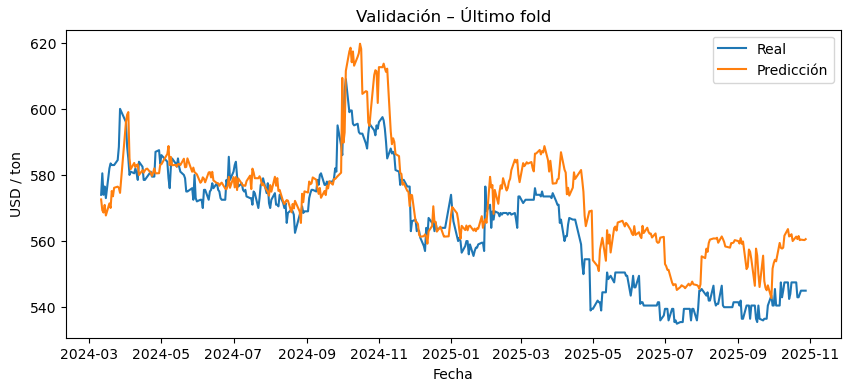

MAE último fold: 9.421864802843144
MAPE último fold: 0.01686096762064686


'\nLa gráfica del último fold simula cómo se comportará tu modelo con datos “reales y recientes”, \nmientras que los folds anteriores son solo para medir estabilidad / MAPE.\n'

In [505]:
# =============================
# GRÁFICA (ÚLTIMO FOLD)
# =============================
y_pred = last_model.predict(last_X_test)

plt.figure(figsize=(10,4))
plt.plot(last_y_test.index, last_y_test.values, label="Real")
plt.plot(last_y_test.index, y_pred, label="Predicción")
plt.legend()
plt.title("Validación – Último fold")
plt.xlabel("Fecha")
plt.ylabel("USD / ton")
plt.show()

print("MAE último fold:", mean_absolute_error(last_y_test, y_pred))
print("MAPE último fold:", mean_absolute_percentage_error(last_y_test, y_pred))

'''
La gráfica del último fold simula cómo se comportará tu modelo con datos “reales y recientes”, 
mientras que los folds anteriores son solo para medir estabilidad / MAPE.
'''

In [506]:
# =============================
# MODELO FINAL (PRODUCCIÓN)
# =============================
final_model = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

final_model.fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)